In [1]:
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
__pyTorch VERSION: 1.13.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
__CUDNN VERSION: 8302
__Number CUDA Devices: 2
__Devices
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, Tesla V100-PCIE-32GB, 460.32.03, 32510 MiB, 3653 MiB, 28857 MiB
1, Tesla V100-PCIE-32GB, 460.32.03, 32510 MiB, 0 MiB, 32510 MiB
2, Tesla V100-PCIE-32GB, 460.32.03, 32510 MiB, 0 MiB, 32510 MiB
Active CUDA Device: GPU 0
Available devices  2
Current cuda device  0


In [3]:
import torch
import sys, os
sys.path.append(os.path.join(os.getcwd(), os.pardir))
from matplotlib import markers, pyplot as plt
from glob import glob
import os
import numpy as np
import torch
from glob import glob
from typing import Callable, List, Tuple, Union, Type
from tqdm.notebook import tqdm, trange
from natsort import natsorted
import torch.nn.functional as F
from torch import nn
from utils.model import Unet
def pad_end_to_end_xz(x):
    dns = x
    padz = torch.cat((dns, dns[..., :-1, :]), -2)
    return torch.cat((padz, padz[..., :-1, :, :]), -3)
def memory_check():
    print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
    print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
    print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

def normalize(x, min, max):
    return ((x - min)/(max-min)-0.5)*2

def unnormalize(x, min, max):
    return (x / 2 + 0.5)*(max-min) + min

path = "/mnt/beegfs/home/zatout/solaire/unet/dataset/dns_coarse_all"
path_filtered_dns = path+"/../"+"les_coarse_all"
ppath_for_coords = path+"/../coord_elem_*"
path_coords = sorted(glob(ppath_for_coords))
path_coord_les = "path/.."
ndns = (384,  384, 266)
nles = (48, 48, 52)
nimages = 5000
# nimages = 10
every_n = 6

dns_files = natsorted(glob(path+"/*"))
les_files = natsorted(glob(path+"/../les_coarse_all/*"))
                 
T = np.array(
    [
        np.fromfile(f, dtype=np.float32).reshape(*nles)
        for f in tqdm(dns_files[::every_n][:nimages], total=len(dns_files[::every_n][:nimages]), position=0, leave=True)
    ]
)

T_les = np.array(
    [
        np.fromfile(f, dtype=np.float32).reshape(*nles)
        for f in tqdm(les_files[::every_n][:nimages], total=len(les_files[::every_n][:nimages]), position=0, leave=True)
    ]
)




  0%|          | 0/822 [00:00<?, ?it/s]

  0%|          | 0/822 [00:00<?, ?it/s]

In [10]:
memory_check()

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


In [11]:
def cor_k(x, x_pad, k):
    return F.conv2d(x_pad[..., k].swapaxes(0, 1), x[..., k], groups=len(x)).sum(1)[0]

def rms_k(x, x_pad, k, npts):
    return F.conv2d(x_pad[..., k].swapaxes(0, 1), x[..., k], groups=len(x)).sum(1)[0]/npts - x[..., k].mean()**2

def cor(x, x_pad, npts):
    return torch.stack([F.conv2d(x_pad[..., k].swapaxes(0, 1), x[..., k], groups=len(x)).sum(1)[0] for k in range(x.shape[-1])], -1)/npts - x.squeeze().mean((0, 1, 2)) ** 2

def rms(x, x_pad, npts):
    return torch.stack([F.conv2d(x_pad[..., k].swapaxes(0, 1), x[..., k], groups=len(x)).sum(1)[0] for k in range(x.shape[-1])], -1)/npts - x.squeeze().mean((0, 1, 2)) ** 2


In [12]:
@torch.no_grad()
def loss_without_grad(
    model, train_loader, label,
    *,
    ret_all_levels=False,
):
    """
    Compute correlations and gives RMSE Loss across reconstructed samples
    """
    model.eval()
    out_loss = []
    recon=[]
    # Forward pass
    for dns, les in train_loader:
        les = les.to("cuda")
        r = les + model(les)
        del les
        recon.append(r)
    r = torch.cat(recon)
    r_pad = pad_end_to_end_xz(r)
    corr_net = rms(r, r_pad, npts)
    l = loss(corr_net/label[0, 0], label/label[0, 0])
    
    out_loss.append(l.item())
    
    model.train()
    # Then we return the sum of losses across correlated snapshot
    if ret_all_levels:
        return np.mean(out_loss), out_loss
    return np.mean(out_loss)


In [13]:
def loss_and_backward(
    neural_net_output, label,
    *,
    memory_debug=False,
    pbar=False,
    ret_all_levels=False,
):
    """
    Compute correlation at each height and runs a backwards pass through it
    """
    out_loss = []
    # We want to accumulate gradients, so we zero_grad before and after
    # gradient computation
    optim.zero_grad()
    if pbar:
        pbar=tqdm(range(nk))
    else:
        pbar=range(nk)
    optim.zero_grad()
    x = neural_net_output
    x_pad = pad_end_to_end_xz(x)
    for k in pbar:
        corr_net = rms_k(x, x_pad, k, npts)
        l = loss(corr_net/label[0, 0, k], label[..., k]/label[0, 0, k])
        l.backward(retain_graph=True)
        out_loss.append(l.item())
    
    if memory_debug:
        memory_check()

    optim.step()
    optim.zero_grad()
    # Then we return the sum of losses across correlated snapshot
    if ret_all_levels:
        return np.mean(out_loss), out_loss
    return np.mean(out_loss)


In [14]:
@torch.no_grad()
def validation_step(
    model, validation_loader, label,
    *,
    ret_outputs = False
):
    model.train(False)
    """
    Compute correlation at each height and runs a backwards pass through it
    """
    out_loss = []
    valid_recon = []
    
    for dns, les in validation_loader:
        les = les.to("cuda")
        dns = dns.to("cuda")
        x = neural_net_output = les + model(les)
        x_pad = pad_end_to_end_xz(x)
        if ret_outputs:
            valid_recon.append(neural_net_output)
        corr_net = rms(x, x_pad, npts)
        # corr_dns = compute_and_stack_corr(dns)
        l = loss(corr_net/label[0, 0], label/label[0, 0])
        out_loss.append(l.item())
    # Then we return the sum of losses across correlated snapshot
    model.train(True)
    if ret_outputs:
        return np.mean(out_loss), valid_recon
    return np.mean(out_loss)

In [9]:
dns_valid = []
les_valid = []
for dns_valid_, les_valid_ in valid:
    dns_valid.append(dns_valid_)
    les_valid.append(les_valid_)
def plot(valid_outputs):
    fig, ax = plt.subplots(3, 3, figsize=(9*1.5, 10), sharex=True, sharey=True)
    
    for i in range(3):
        im = ax[i][0].imshow(dns_valid    [0][0, ..., (i+1)*52//4].squeeze().detach().cpu(), vmin=-1, vmax=1, extent=[0, 1.5, 0, 1])
        ax[i][1]     .imshow(les_valid    [0][0, ..., (i+1)*52//4].squeeze().detach().cpu(), vmin=-1, vmax=1, extent=[0, 1.5, 0, 1])
        ax[i][2]     .imshow(valid_outputs[0][0, ..., (i+1)*52//4].squeeze().detach().cpu(), vmin=-1, vmax=1, extent=[0, 1.5, 0, 1])
    ax[0][0].set_title(r"DNS (aim)")
    ax[0][1].set_title(r"LES (input)")
    ax[0][2].set_title(r"Neural net (ours)") # , x=.5, y=1.1)
    cbar_ax = fig.add_axes([1.01, .25, 0.05, 0.5])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
    cbar.set_ticks([
        *np.linspace(-1, 1, 6) #int((max_ + min_)/2),int(max_-1)
    ])
    
    cbar.ax.xaxis.set_label_position('top')


NameError: name 'valid' is not defined

In [15]:
tmin, tmax = 293, 586
T_les_torch = normalize(torch.from_numpy(T_les).unsqueeze(1), tmin, tmax)
T_torch = normalize(torch.from_numpy(T).unsqueeze(1), tmin, tmax)

def seed_everything(seed: int):
    # https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(0)

ntrain = int(len(T_torch)*.8)
nval = len(T_torch) - ntrain
dns, les = T_torch[:ntrain, ..., -16:], T_les_torch[:ntrain, ..., -16:]
dns_val, les_val = T_torch[ntrain:], T_les_torch[ntrain:]
nt, ni, nj, nk = dns.squeeze().shape
npts = nt * ni * nj
train_dataset = torch.utils.data.TensorDataset(dns, les)
valid_dataset = torch.utils.data.TensorDataset(dns_val, les_val)
batch_size_train = 40
batch_size_valid = 100
train = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size_train)
valid = torch.utils.data.DataLoader(valid_dataset, shuffle=False, batch_size=batch_size_valid)

In [19]:
dns_cuda = dns.to("cuda")
dns_pad_cuda = pad_end_to_end_xz(dns_cuda)
%time label = rms(dns_cuda, dns_pad_cuda, npts)

del dns_cuda
del dns_pad_cuda

dns_val_cuda = dns_val.to("cuda")
dns_val_pad_cuda = pad_end_to_end_xz(dns_val_cuda)
%time label_val = rms(dns_val_cuda, dns_val_pad_cuda, npts)

del dns_val_cuda
del dns_val_pad_cuda


CPU times: user 3 ms, sys: 0 ns, total: 3 ms
Wall time: 1.51 ms
CPU times: user 8.91 ms, sys: 0 ns, total: 8.91 ms
Wall time: 4.85 ms


In [20]:
seed_everything(0)
model = net = Unet(3, "same", 2, last_act="tanh").to("cuda")

In [21]:
memory_check()

torch.cuda.memory_allocated: 0.005872GB
torch.cuda.memory_reserved: 0.628906GB
torch.cuda.max_memory_reserved: 0.628906GB


In [22]:
def recon_batch(model, loader, height_limit=16):
    
    for dns, les in train:
        les = les.to("cuda")[..., -height_limit:]
        memory_check()
        r = les + model(les)
        memory_check()
        del les
        recon.append(r)
    r = torch.cat(recon)# .cpu()
    return r

In [23]:
model = Unet(3, "same", 2, last_act="tanh").to("cuda")

In [25]:
recon = []
for _, l in train:
    l = l.to("cuda")
    memory_check()
    r = l + model(l)
    memory_check()
    del l
    recon.append(r)
r = torch.cat(recon)# .cpu()
return r

torch.cuda.memory_allocated: 2.576478GB
torch.cuda.memory_reserved: 3.287109GB
torch.cuda.max_memory_reserved: 3.464844GB
torch.cuda.memory_allocated: 2.570985GB
torch.cuda.memory_reserved: 5.964844GB
torch.cuda.max_memory_reserved: 5.964844GB
torch.cuda.memory_allocated: 2.576478GB
torch.cuda.memory_reserved: 5.964844GB
torch.cuda.max_memory_reserved: 5.964844GB
torch.cuda.memory_allocated: 5.130809GB
torch.cuda.memory_reserved: 6.914062GB
torch.cuda.max_memory_reserved: 6.914062GB
torch.cuda.memory_allocated: 5.136302GB
torch.cuda.memory_reserved: 6.914062GB
torch.cuda.max_memory_reserved: 6.914062GB
torch.cuda.memory_allocated: 7.690633GB
torch.cuda.memory_reserved: 8.570312GB
torch.cuda.max_memory_reserved: 8.570312GB
torch.cuda.memory_allocated: 7.696126GB
torch.cuda.memory_reserved: 8.570312GB
torch.cuda.max_memory_reserved: 8.570312GB
torch.cuda.memory_allocated: 10.250457GB
torch.cuda.memory_reserved: 11.072266GB
torch.cuda.max_memory_reserved: 11.072266GB
torch.cuda.memory_all

OutOfMemoryError: CUDA out of memory. Tried to allocate 540.00 MiB (GPU 0; 31.75 GiB total capacity; 29.93 GiB already allocated; 133.50 MiB free; 30.45 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

  0%|          | 0/1 [00:00<?, ?it/s]

torch.cuda.memory_allocated: 2.151568GB
torch.cuda.memory_reserved: 3.337891GB
torch.cuda.max_memory_reserved: 10.570312GB
torch.cuda.memory_allocated: 0.847506GB
torch.cuda.memory_reserved: 3.375000GB
torch.cuda.max_memory_reserved: 10.570312GB
torch.cuda.memory_allocated: 0.865359GB
torch.cuda.memory_reserved: 3.375000GB
torch.cuda.max_memory_reserved: 10.570312GB
torch.cuda.memory_allocated: 1.615527GB
torch.cuda.memory_reserved: 3.375000GB
torch.cuda.max_memory_reserved: 10.570312GB
torch.cuda.memory_allocated: 1.633379GB
torch.cuda.memory_reserved: 3.375000GB
torch.cuda.max_memory_reserved: 10.570312GB
torch.cuda.memory_allocated: 2.385760GB
torch.cuda.memory_reserved: 3.880859GB
torch.cuda.max_memory_reserved: 10.570312GB
torch.cuda.memory_allocated: 2.403613GB
torch.cuda.memory_reserved: 3.880859GB
torch.cuda.max_memory_reserved: 10.570312GB
torch.cuda.memory_allocated: 3.156847GB
torch.cuda.memory_reserved: 4.458984GB
torch.cuda.max_memory_reserved: 10.570312GB
torch.cuda.memor

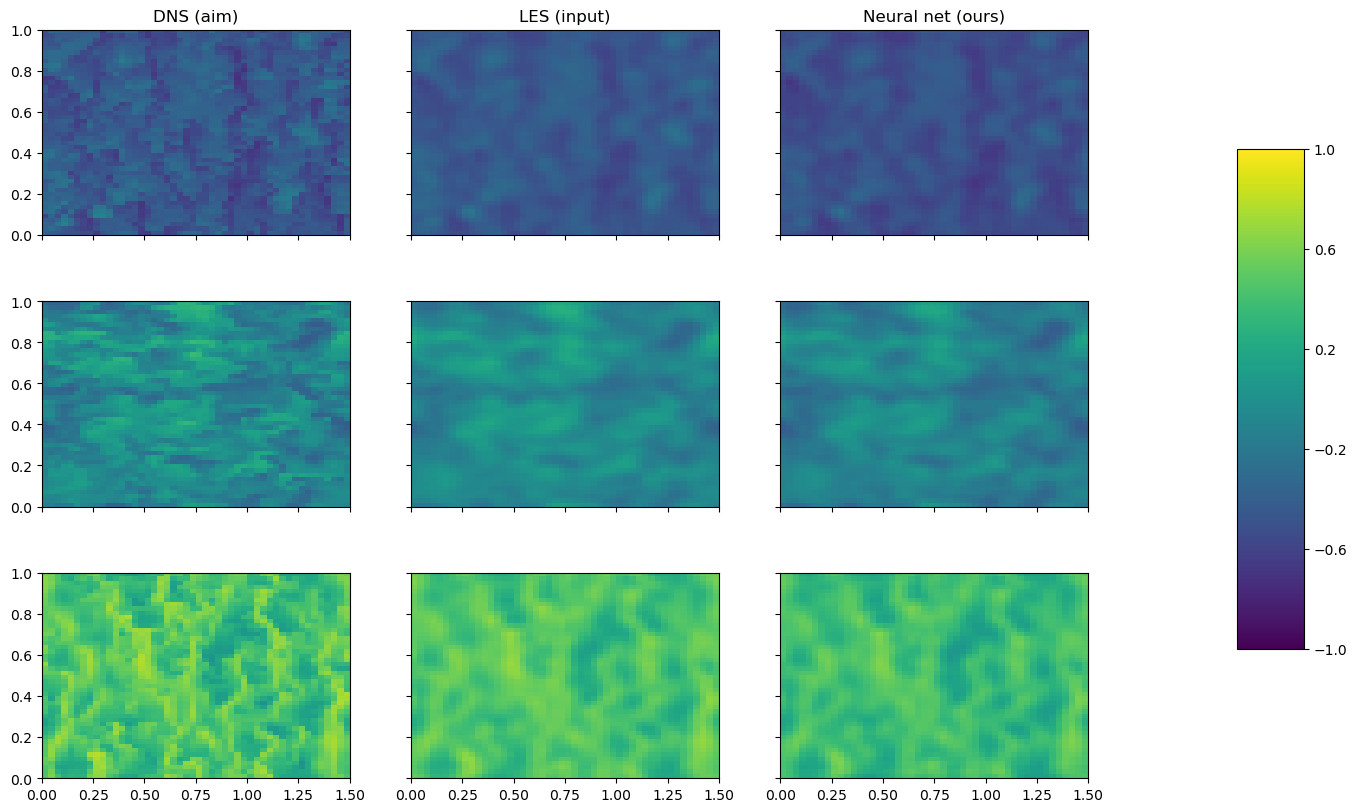

In [33]:
save = False

if save:
    current_time = strftime("%d-%m-%Y_%H-%S-%M", gmtime())
    os.makedirs(os.path.join("correlations/", current_time), exist_ok=True)

seed_everything(0)
model = Unet(3, "same", 2, last_act="tanh").to("cuda")
# model = torch.nn.Sequential(torch.nn.Conv3d(1, 2, 3, padding="same"), torch.nn.SELU(), torch.nn.Conv3d(2, 1, 3, padding="same"), torch.nn.Tanh()).to("cuda")



seed_everything(0)
# model = Unet(3, "same", 2, last_act="tanh").to("cuda")
model = torch.nn.Sequential(
    torch.nn.Conv3d(1, 2, 3, padding="same"),
    torch.nn.SELU(),
    torch.nn.Conv3d(2, 4, 3, padding="same"),
    torch.nn.SELU(),
    torch.nn.Conv3d(4, 8, 3, padding="same"),
    torch.nn.SELU(),
    torch.nn.Conv3d(8, 4, 3, padding="same"),
    torch.nn.SELU(),
    torch.nn.Conv3d(4, 2, 3, padding="same"),
    torch.nn.SELU(),
    torch.nn.Conv3d(2, 1, 3, padding="same"),
    torch.nn.Tanh()
).to("cuda")

initial_lr = 1e-3

if save:
    current_time = strftime("%d-%m-%Y_%H-%S-%M", gmtime())
    os.makedirs(os.path.join("correlations/", current_time), exist_ok=True)
loss = lambda x, y: torch.sqrt(nn.MSELoss()(x, y))
optim = torch.optim.Adam(model.parameters(), initial_lr)
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optim, lr_lambda=lambda epoch: .978)

epochs = 1

valid_every = 1
save_every = 1e6
scheduler_every = 11
plot_every = 10
plot_valid = True

v_losses = []
pbar = tqdm(range(1, epochs+1))
losses = [loss_without_grad(model, train, label)]
v_losses = [validation_step(model, valid, label_val)]
for epoch in pbar:
    recon=[]
    for dns, les in train:
        
        les = les.to("cuda")
        memory_check()
        r = les + model(les)
        memory_check()
        del les
        recon.append(r)
    r = torch.cat(recon)# .cpu()
    
    
    epoch_loss = loss_and_backward(r, label)
    losses.append(epoch_loss)
    
    if epoch % valid_every  == 0:
        vloss, valid_outputs = validation_step(model, valid, label_val, ret_outputs=True)
        v_losses.append(vloss)
        if plot_valid:
            plot(valid_outputs)
        if save:
            plt.savefig(os.path.join("correlations/", current_time, f"valid_epoch_{epoch}.pdf"))
        # plt.close()
        
    if epoch % save_every == 0 and save:
        torch.save(model, os.path.join("correlations/", current_time, f"model_epoch_{epoch}.pth"))
    # optim.param_groups[-1]["lr"] >= 1e-6
    if epoch % scheduler_every == 0 and optim.param_groups[-1]["lr"] >= limit_lr:
        scheduler.step()
    pbar.set_description(f"Epoch: {epoch}, Loss: {epoch_loss:.3e}, Valid loss: {vloss:.3e}")
if save:
    np.array(losses).tofile(os.path.join("correlations/", current_time, "losses.npy"))
    np.array(v_losses).tofile(os.path.join("correlations/", current_time, "v_losses.npy"))
# plt.figure()
# plt.plot(losses, "k^-", label="train")
# plt.plot(v_losses, "r^-", label="valid")
# plt.legend()